In [14]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import seaborn as sns

from numpy import array
from numpy import asarray
from numpy import zeros
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPooling2D
from keras.layers.embeddings import Embedding
from keras.layers.core import Activation, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [5]:
movie_reviews = pd.read_csv('imdb\IMDB Dataset.csv')

In [6]:
movie_reviews.isnull().values.any()

False

In [7]:
movie_reviews.shape

(50000, 2)

In [8]:
movie_reviews.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


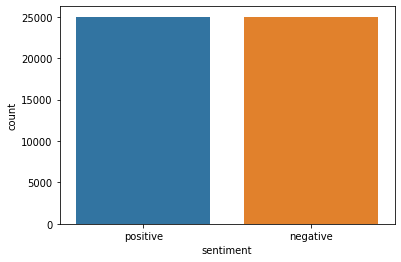

In [11]:
sns.countplot(x='sentiment', data=movie_reviews)

In [12]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)


def preprocess_text(sen):
    sentence = remove_tags(sen)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))
    
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=='positive' else 0, y)))

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [13]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [16]:
embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding='utf8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] =vector_dimensions
glove_file.close()

In [18]:
embedding_matrix = zeros((vocab_size, 100))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

#### Vanilla NN

In [21]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix],
                           input_length=maxlen, trainable=False)

model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          9254700   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10001     
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [24]:
history = model.fit(X_train, y_train, batch_size=128, epochs=3,
                   verbose=1, validation_split=0.2)

Epoch 1/3
250/250 [==============================] - 2s 7ms/step - loss: 0.6054 - acc: 0.6712 - val_loss: 0.5340 - val_acc: 0.7333
Epoch 2/3
250/250 [==============================] - 1s 6ms/step - loss: 0.4970 - acc: 0.7617 - val_loss: 0.5456 - val_acc: 0.7226
Epoch 3/3
250/250 [==============================] - 1s 6ms/step - loss: 0.4582 - acc: 0.7862 - val_loss: 0.5182 - val_acc: 0.7466


In [26]:
score = model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.5192 - acc: 0.7427


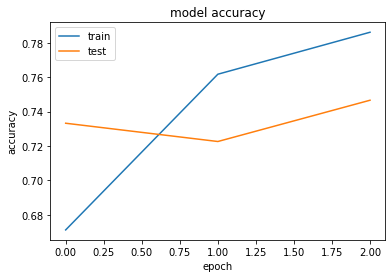

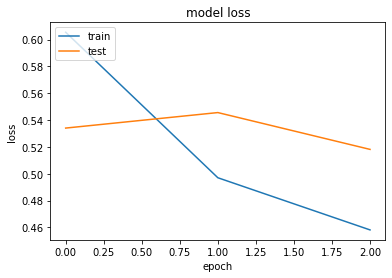

In [28]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## CNN

In [32]:
from keras.layers import Conv1D, GlobalMaxPooling1D
cnn_model = Sequential()
cnn_model.add(embedding_layer)
cnn_model.add(Conv1D(128,5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          9254700   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 9,318,957
Trainable params: 64,257
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [34]:
cnn_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=3, verbose=1, validation_split=0.2)
score = cnn_model.evaluate(X_test, y_test, verbose=1)

Epoch 1/3
250/250 [==============================] - 16s 63ms/step - loss: 0.5025 - acc: 0.7508 - val_loss: 0.3987 - val_acc: 0.8200
Epoch 2/3
250/250 [==============================] - 15s 60ms/step - loss: 0.3676 - acc: 0.8388 - val_loss: 0.3685 - val_acc: 0.8349
Epoch 3/3
313/313 [==============================] - 2s 6ms/step - loss: 0.3497 - acc: 0.8459


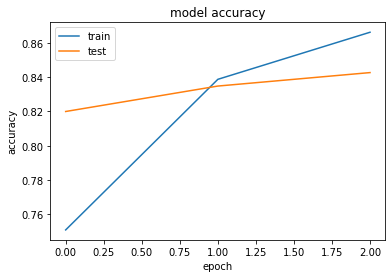

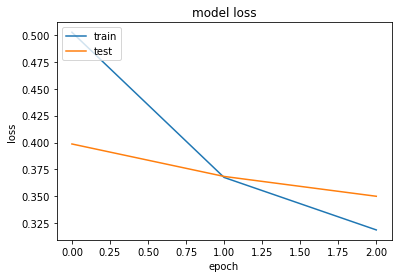

In [36]:
plt.plot(cnn_history.history['acc'])
plt.plot(cnn_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## LSTM

In [38]:
from keras.layers import LSTM
rnn_model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
rnn_model.add(embedding_layer)
rnn_model.add(LSTM(128))

rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [39]:
print(rnn_model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [40]:
rnn_history = rnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

rnn_score = rnn_model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 49s 195ms/step - loss: 0.5612 - acc: 0.7084 - val_loss: 0.4554 - val_acc: 0.7885
Epoch 2/6
250/250 [==============================] - 48s 191ms/step - loss: 0.4381 - acc: 0.7974 - val_loss: 0.3953 - val_acc: 0.8180
Epoch 3/6
250/250 [==============================] - 50s 200ms/step - loss: 0.3916 - acc: 0.8218 - val_loss: 0.3672 - val_acc: 0.8321
Epoch 4/6
250/250 [==============================] - 49s 195ms/step - loss: 0.3669 - acc: 0.8374 - val_loss: 0.3645 - val_acc: 0.8332
Epoch 5/6
250/250 [==============================] - 48s 192ms/step - loss: 0.3508 - acc: 0.8443 - val_loss: 0.3764 - val_acc: 0.8300
Epoch 6/6
313/313 [==============================] - 9s 30ms/step - loss: 0.3789 - acc: 0.8292


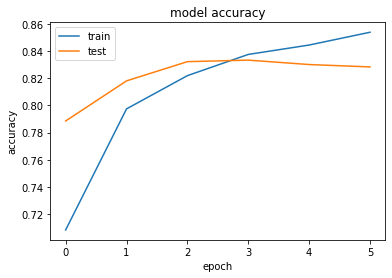

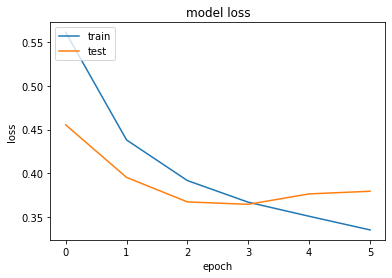

In [41]:
plt.plot(rnn_history.history['acc'])
plt.plot(rnn_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(rnn_history.history['loss'])
plt.plot(rnn_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [52]:
instance = X[50]
print(instance)

Return to the th Chamber is one of those classic Kung Fu movies which Shaw produces back in the and whose genre is equivalent to the spaghetti westerns of Hollywood and the protagonist Gordon Liu the counterpart to the western Clint Eastwood Digitally remastered and new print made for the Fantastic Film Fest this is Presented in Shaw Scope just like the good old days This film is simple story of good versus evil told in acts which more or less sums up the narrative of martial arts films in that era Act One sets up the premise Workers in dye mill of small village are unhappy with their lot having their wages cut by by incoming manchu gangsters They can do much about their exploitation because none of them are martial arts skilled to take on the gangsters and their boss At first they had minor success in getting Liu to impersonate highly skilled Shaolin monk one of the best comedy sequences but their rouse got exposed when they pushed the limit of credibility by impersonating one too man

In [53]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

print(model.predict(instance))
print(cnn_model.predict(instance))
print(rnn_model.predict(instance))

[[0.99770844]]
[[0.9733453]]
[[0.7389234]]


In [54]:
y[50]

1